# Building a deep belief network

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from tqdm import tqdm

import sys
sys.path.append('../..')

from logger import setup_logging
from models import DBN
from utils import (
    dataset,
    test,
    train,
    utils,
    visualisation
)

In [2]:
LOG_CONFIG_PATH = os.path.join(os.path.abspath("../.."), "logger", "logger_config.json")
LOG_DIR   = os.path.join(os.path.abspath("../.."), "logs")
DATA_DIR  = os.path.join(os.path.abspath("../.."), "data")
IMAGE_DIR = os.path.join(os.path.abspath("../.."), "images")

Check if GPU is active.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [4]:
utils.mkdir(LOG_DIR)
setup_logging(save_dir=LOG_DIR, log_config=LOG_CONFIG_PATH)

### Create the DataLoader

In [13]:
# Get the datasets
train_data, val_data, test_data = dataset.get_dataset(data_path=DATA_DIR, balanced=False)

train_data.labels[train_data.labels == 6] = 5
val_data.labels[val_data.labels == 6] = 5
test_data.labels[test_data.labels == 6] = 5

# How many instances have we got?
print('# instances in training set: ', len(train_data))
print('# instances in validation set: ', len(val_data))
print('# instances in testing set: ', len(test_data))

batch_size = 128

# Create the dataloaders - for training, validation and testing
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# instances in training set:  1455436
# instances in validation set:  485146
# instances in testing set:  485145


### Instantiate the network, the loss function and the optimizer 构建DBN模型，损失函数、修改器

In [6]:
# Defining some input variables
n_classes = 6
num_epochs = 3

# Creating a DBN
model = DBN(n_visible=49,
            n_hidden=(128, 64),
            k=(1, 1),
            learning_rate=(0.1, 0.1),
            momentum=(0, 0),
            decay=(0, 0), 
            batch_size=[64, 64],
            num_epochs=[1, 1],
            device=device)

# Training a DBN
model.fit(train_loader)

# Creating the optimzers
optimizer = [optim.Adam(m.parameters(), lr=0.001) for m in model.models]
optimizer.append(optim.Adam(model.fc.parameters(), lr=0.001))

INFO 2024-04-29 16:54:37,557 | DBN.py:184 | Fitting layer 1/2


100%|████████████████████████████████████████████████████████████████████████████| 11371/11371 [06:21<00:00, 29.84it/s]

INFO 2024-04-29 17:00:58,647 | RBM.py:269 | Epoch 1/1 - MSE: 6.815149784088135 - Pseudo-Likelihood: -13.20061206817627


INFO 2024-04-29 17:01:01,852 | DBN.py:184 | Fitting layer 2/2


100%|███████████████████████████████████████████████████████████████████████████| 22742/22742 [01:41<00:00, 224.69it/s]

INFO 2024-04-29 17:02:43,070 | RBM.py:269 | Epoch 1/1 - MSE: 20.924301147460938 - Pseudo-Likelihood: -41.169273376464844


In [8]:
torch.save(model, 'DBN.model')
print(model)

DBN(
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [9]:
criterion = nn.CrossEntropyLoss()

### Train it

In [14]:
model = torch.load("DBN.model")
history = train(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device)

training_loss = history['train']['loss']
training_accuracy = history['train']['accuracy']
train_output_true = history['train']['output_true']
train_output_pred = history['train']['output_pred']

validation_loss = history['valid']['loss']
validation_accuracy = history['valid']['accuracy']
valid_output_true = history['valid']['output_true']
valid_output_pred = history['valid']['output_pred']

INFO 2024-04-29 17:22:18,724 | train.py:80 | Epoch 1/3:


100%|████████████████████████████████████████████████████████████████████████████| 11371/11371 [05:46<00:00, 32.85it/s]


INFO 2024-04-29 17:29:48,004 | train.py:153 | loss: 0.043801434368857736 - acc: 0.9887957972731195 - val_loss: 0.01549921291138089 - val_acc: 0.9962423682767662
INFO 2024-04-29 17:29:48,006 | train.py:80 | Epoch 2/3:


100%|████████████████████████████████████████████████████████████████████████████| 11371/11371 [05:47<00:00, 32.74it/s]


INFO 2024-04-29 17:37:17,887 | train.py:153 | loss: 0.013736591951310235 - acc: 0.99652269148214 - val_loss: 0.011817311773459157 - val_acc: 0.9970194539375775
INFO 2024-04-29 17:37:17,888 | train.py:80 | Epoch 3/3:


100%|████████████████████████████████████████████████████████████████████████████| 11371/11371 [05:48<00:00, 32.58it/s]


INFO 2024-04-29 17:44:51,255 | train.py:153 | loss: 0.011605803449758022 - acc: 0.997000898699771 - val_loss: 0.010215050896156137 - val_acc: 0.9971761078108445
INFO 2024-04-29 17:44:51,257 | train.py:155 | Finished Training


### Plot loss vs iterations 画损失和准确率变化图

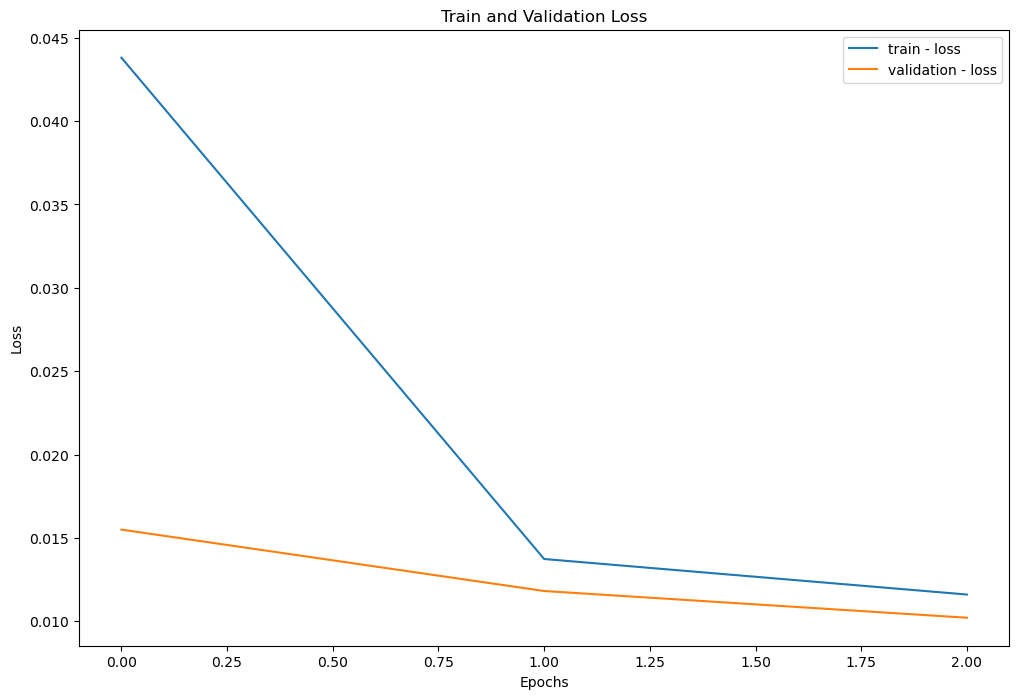

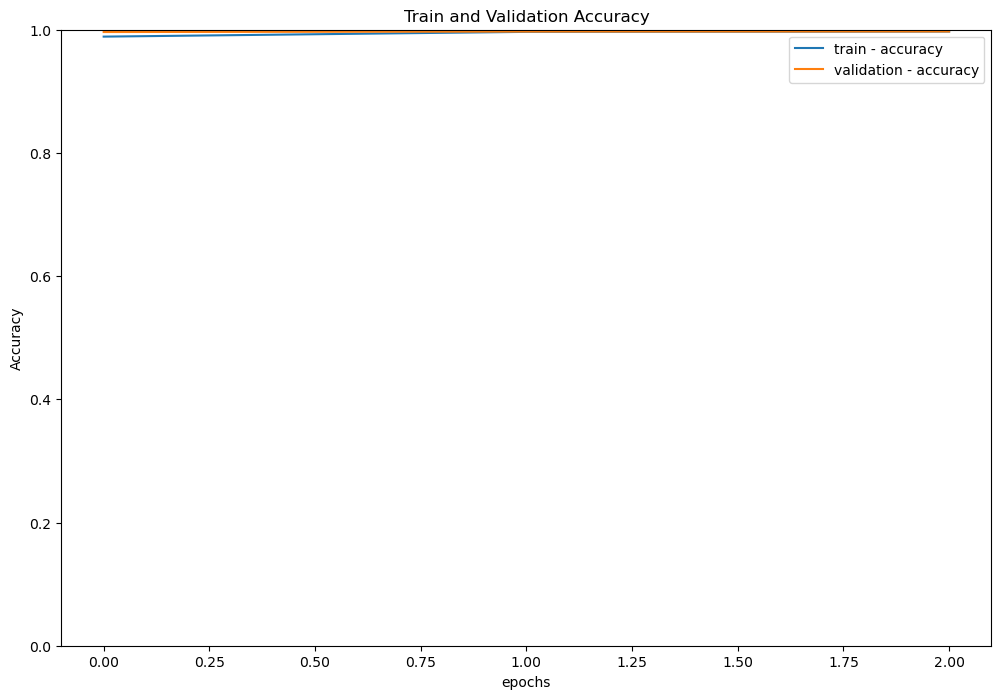

In [17]:
fig = plt.figure(figsize=(12, 8))
plt.plot(training_loss, label='train - loss')
plt.plot(validation_loss, label='validation - loss')
plt.title("Train and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

fig = plt.figure(figsize=(12, 8))
plt.plot(training_accuracy, label='train - accuracy')
plt.plot(validation_accuracy, label='validation - accuracy')
plt.title("Train and Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc="best")
plt.show()

### Plot confusion matrix 画混淆矩阵

C:\Users\tangy\Desktop\Files\信安赛\projects\dbn-based-nids-master\notebooks\DeepBeliefNetwork\../..\utils\visualisation.py:12: RuntimeWarning: invalid value encountered in divide
  recall_confusion_mtx = confusion_mtx / confusion_mtx.sum(axis=0)


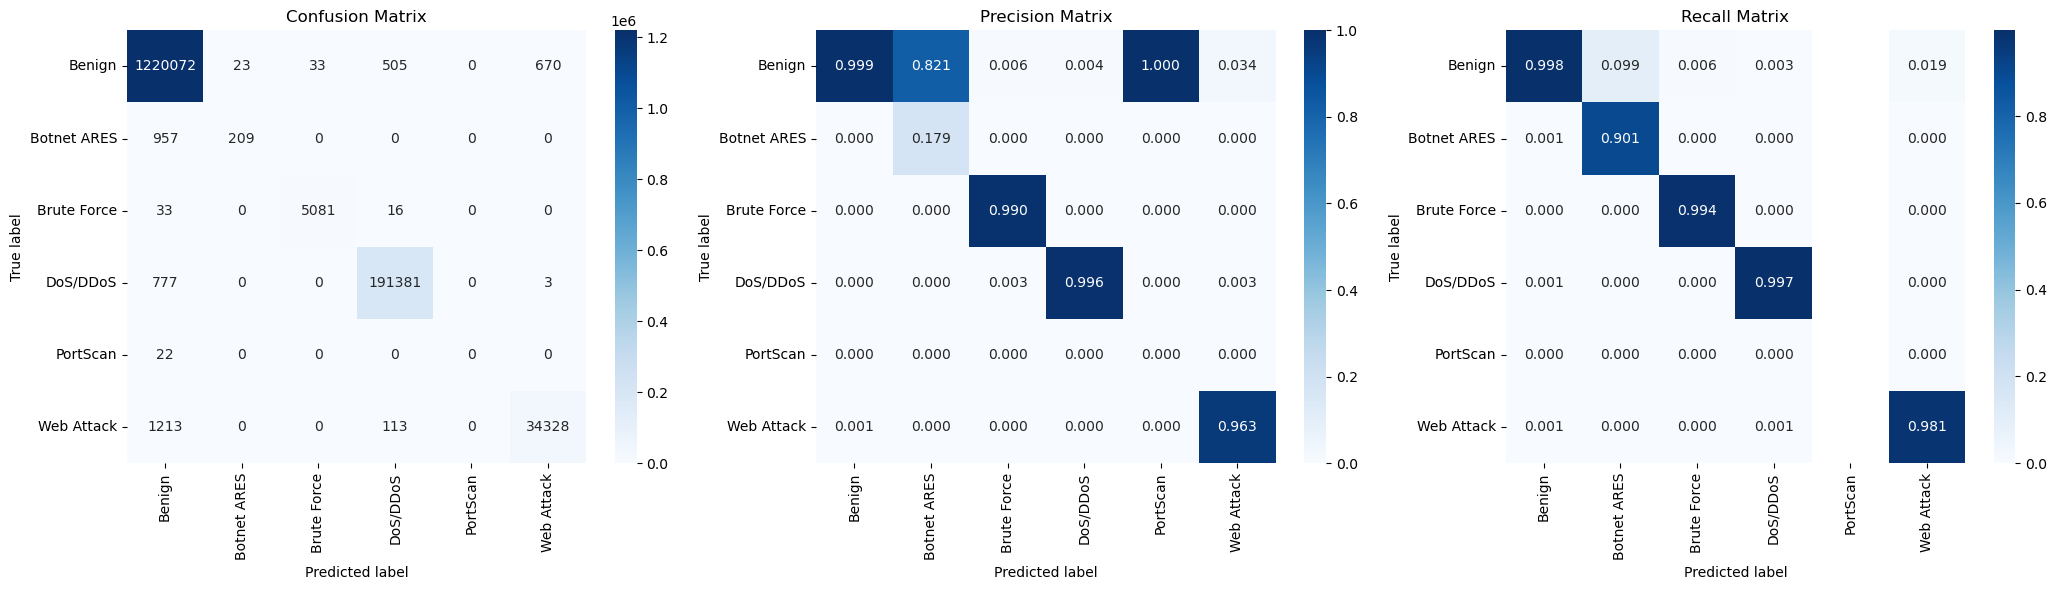

In [18]:
labels = ['Benign', 'Botnet ARES', 'Brute Force', 'DoS/DDoS', 'PortScan', 'Web Attack']

visualisation.plot_confusion_matrix(y_true=train_output_true,
                                    y_pred=train_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_dbn_train_confusion_matrix.pdf")

In [19]:
from sklearn.metrics import classification_report

print("Training Set -- Classification Report", end="\n\n")
print(classification_report(train_output_true, train_output_pred, target_names=labels))

Training Set -- Classification Report



C:\Users\tangy\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tangy\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00   1221303
 Botnet ARES       0.90      0.18      0.30      1166
 Brute Force       0.99      0.99      0.99      5130
    DoS/DDoS       1.00      1.00      1.00    192161
    PortScan       0.00      0.00      0.00        22
  Web Attack       0.98      0.96      0.97     35654

    accuracy                           1.00   1455436
   macro avg       0.81      0.69      0.71   1455436
weighted avg       1.00      1.00      1.00   1455436



C:\Users\tangy\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\tangy\Desktop\Files\信安赛\projects\dbn-based-nids-master\notebooks\DeepBeliefNetwork\../..\utils\visualisation.py:12: RuntimeWarning: invalid value encountered in divide
  recall_confusion_mtx = confusion_mtx / confusion_mtx.sum(axis=0)


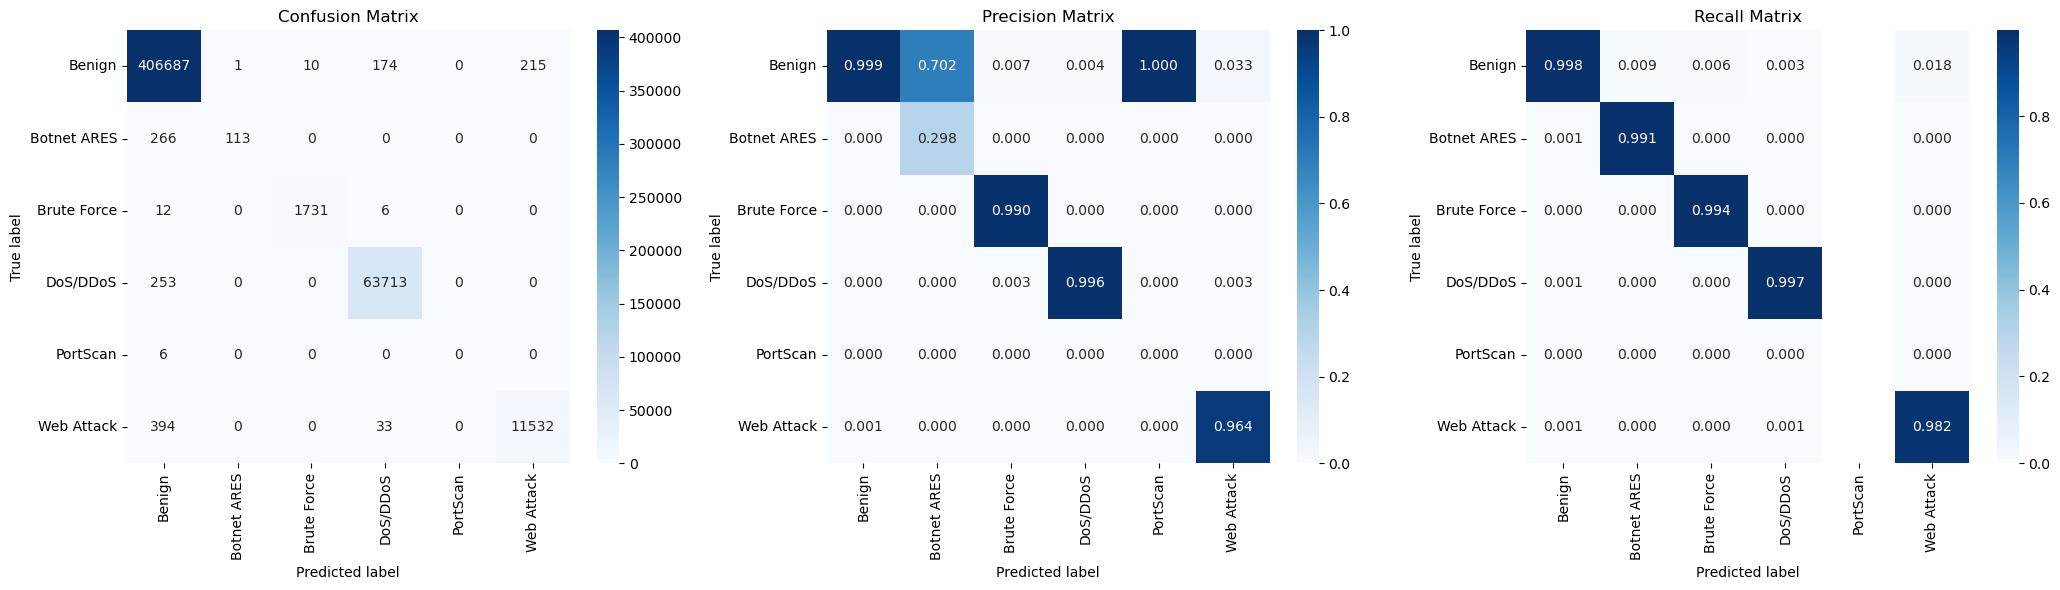

In [20]:
visualisation.plot_confusion_matrix(y_true=valid_output_true,
                                    y_pred=valid_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_dbn_valid_confusion_matrix.pdf")

In [21]:
print("Validation Set -- Classification Report", end="\n\n")
print(classification_report(valid_output_true, valid_output_pred, target_names=labels))

Validation Set -- Classification Report



C:\Users\tangy\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    407087
 Botnet ARES       0.99      0.30      0.46       379
 Brute Force       0.99      0.99      0.99      1749
    DoS/DDoS       1.00      1.00      1.00     63966
    PortScan       0.00      0.00      0.00         6
  Web Attack       0.98      0.96      0.97     11959

    accuracy                           1.00    485146
   macro avg       0.83      0.71      0.74    485146
weighted avg       1.00      1.00      1.00    485146



C:\Users\tangy\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tangy\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Test it

In [22]:
#################
### TEST LOOP ###
#################
history = test(model, criterion, test_loader, device)

test_output_true = history['test']['output_true']
test_output_pred = history['test']['output_pred']
test_output_pred_prob = history['test']['output_pred_prob']

100%|██████████████████████████████████████████████████████████████████████████████| 3791/3791 [01:56<00:00, 32.51it/s]

INFO 2024-04-29 21:13:39,627 | test.py:82 | Test loss: 0.010804423897912733, Test accuracy: 0.996984406723763


### Classification Report

C:\Users\tangy\Desktop\Files\信安赛\projects\dbn-based-nids-master\notebooks\DeepBeliefNetwork\../..\utils\visualisation.py:12: RuntimeWarning: invalid value encountered in divide
  recall_confusion_mtx = confusion_mtx / confusion_mtx.sum(axis=0)


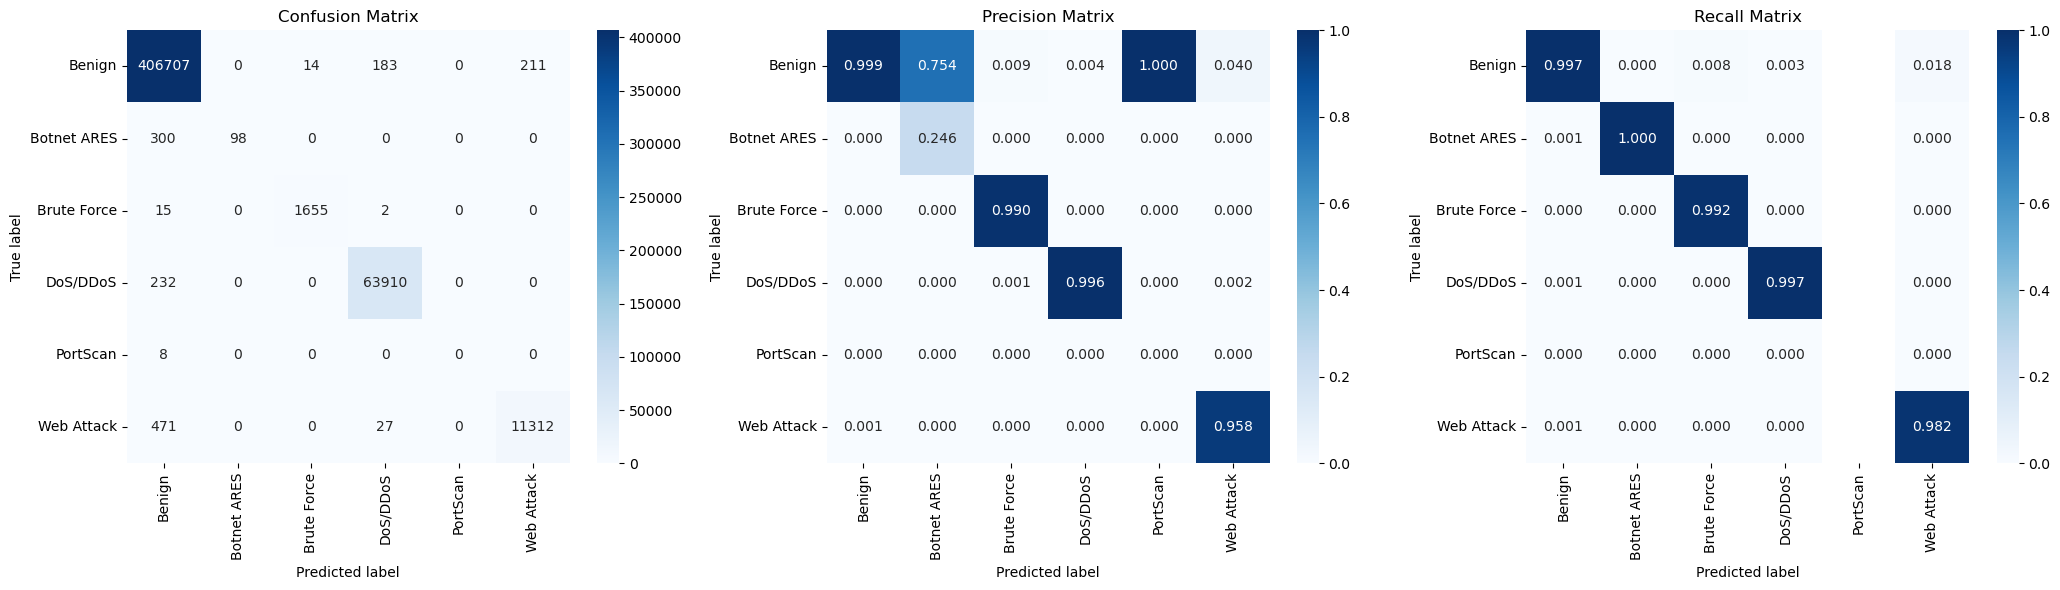

In [23]:
visualisation.plot_confusion_matrix(y_true=test_output_true,
                                    y_pred=test_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_dbn_test_confusion_matrix.pdf")

In [24]:
print("Testing Set -- Classification Report", end="\n\n")
print(classification_report(test_output_true, test_output_pred, target_names=labels))

Testing Set -- Classification Report



C:\Users\tangy\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    407115
 Botnet ARES       1.00      0.25      0.40       398
 Brute Force       0.99      0.99      0.99      1672
    DoS/DDoS       1.00      1.00      1.00     64142
    PortScan       0.00      0.00      0.00         8
  Web Attack       0.98      0.96      0.97     11810

    accuracy                           1.00    485145
   macro avg       0.83      0.70      0.73    485145
weighted avg       1.00      1.00      1.00    485145



C:\Users\tangy\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tangy\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Plot ROC curve

In [25]:
y_test = pd.get_dummies(test_output_true).values
y_score = np.array(test_output_pred_prob)

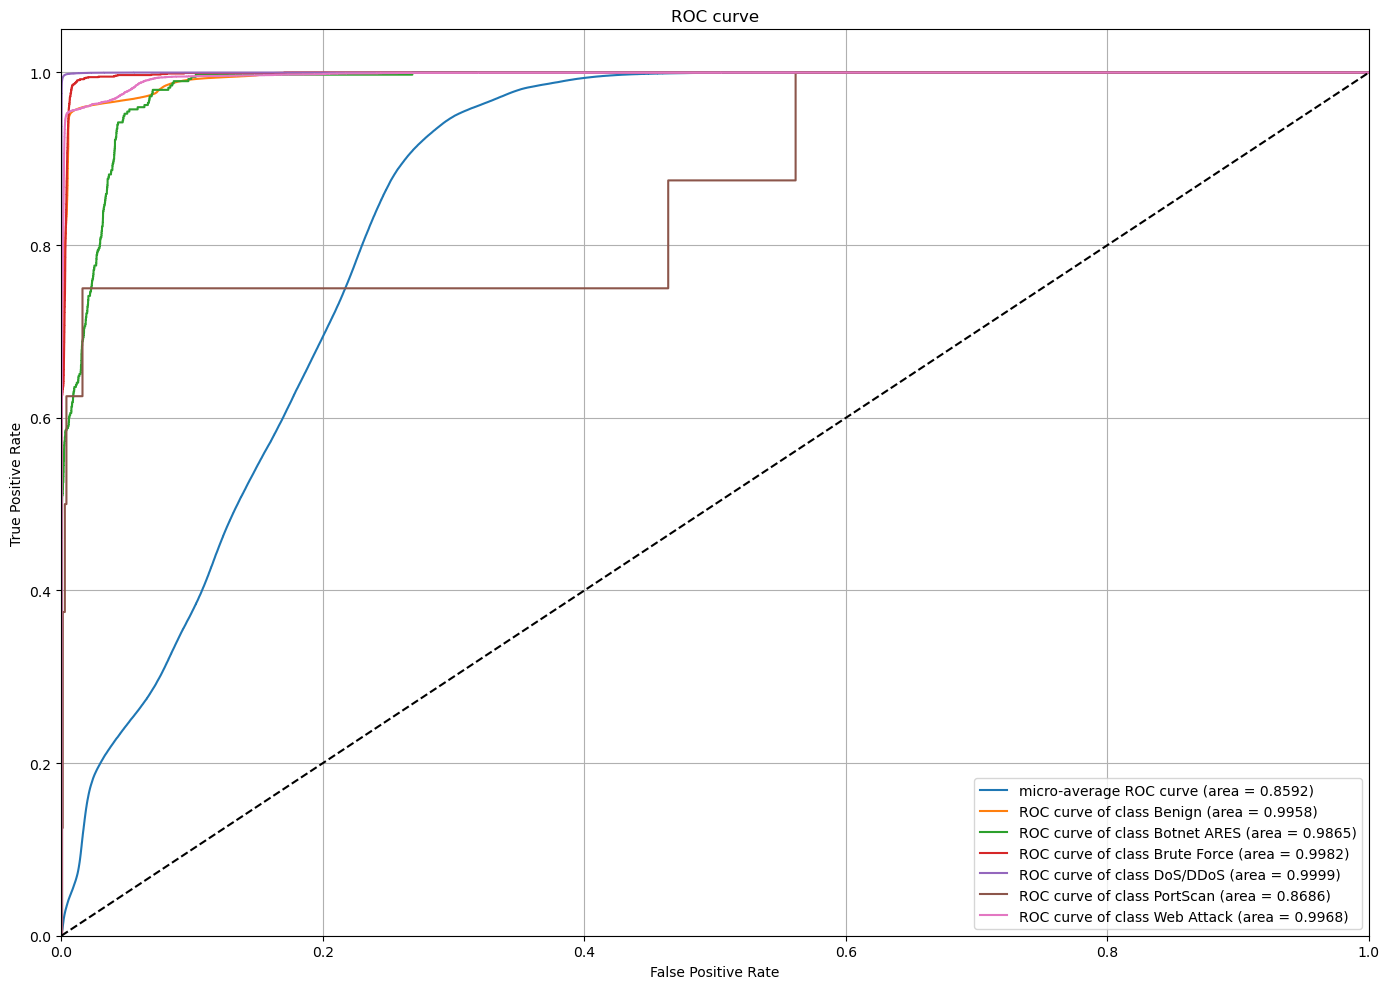

In [26]:
visualisation.plot_roc_curve(y_test=y_test,
                             y_score=y_score,
                             labels=labels,
                             save=True,
                             save_dir=IMAGE_DIR,
                             filename="imb_dbn_roc_curve.pdf")

### Plot Precision vs. Recall curve

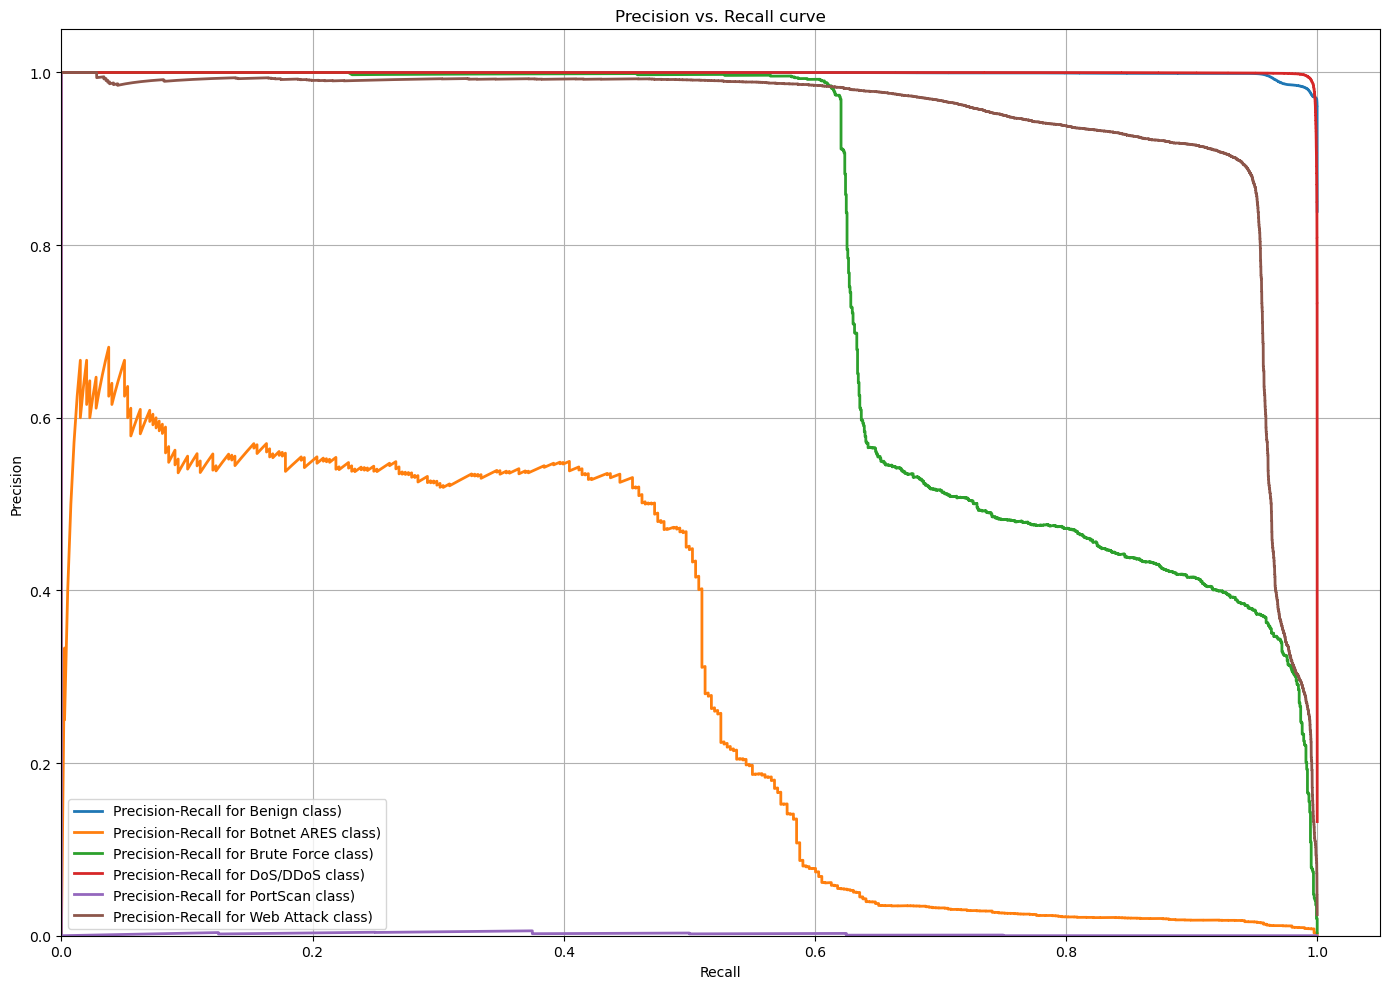

In [27]:
visualisation.plot_precision_recall_curve(y_test=y_test,
                                          y_score=y_score,
                                          labels=labels,
                                          save=True,
                                          save_dir=IMAGE_DIR,
                                          filename="imb_dbn_prec_recall_curve.pdf")